In [1]:
import random
import matplotlib.pyplot as plt
import warnings
import numpy as np

warnings.filterwarnings("ignore")
rs = np.random.RandomState(0)
% matplotlib inline
% config InlineBackend.figure_format = 'svg'
#import matplotlib;matplotlib.rcParams['font.size'] = 16
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
from visualize import *
from calibration import *
from active_learning import *
from collections import defaultdict
from tqdm import tqdm
from spline import *
import collections


NUM_BINS = 10
NUM_CLASSES =  100
NUM_CLASSES_PLOT = 4
NUM_COL = 5
NUM_RUN = 50
# limit to the cases when the number of samples is less than 1000
NUM_SAMPLES = [20, 30, 40, 50, 60, 70, 80, 90, 100] + [50 * _ for _ in range(3, 19)] 
print len(NUM_SAMPLES) # should not exceed 25 because the number of subplots is set to be 25.
METHOD_NAME = "binary_spline"

25
25


try out the PyGAM package (e.g., Logistic GAM with splines) for one or more of our datasets (e.g., p(y=1 | max_k s_k(x)) for calibration, or Accuracy( g (x) ) versus g(x) where g(x) is brightness - to get a sense whether this approach is a bit more robust than (say) GP classification methods.

In [2]:
# # Load prediction from ResNet on CIFAR100 test data, which contains 10,000 images. 
# # https://github.com/rloganiv/pytorch-classification/blob/master/predict.py
# # data: a numpy array of size 10,000 * 101. For each row, the first entry is the true label,
# #       following by softmax of output logits of this image for each class.
# # DATASET = "cifar100/cifar100_predictions_dropout"
# DATASET = "cifar100_predictions_dropout"
# data = np.genfromtxt("data/cifar100/%s.txt" % DATASET)# 10000*101
# N = data.shape[0]
# score = data[:,1:]
# Y_predict = np.argmax(score, axis=1)
# Y_true = data[:,0]
# print "ACC=%.4f" % ((Y_predict == Y_true).sum() * 1.0/ N)


# DATASET = "svhn_predictions"
# data = np.genfromtxt("data/svhn/%s.txt" % DATASET)# 10000*101
# N = data.shape[0]
# score = data[:,1:]
# Y_predict = np.argmax(score, axis=1)
# Y_true = data[:,0]


DATASET = "cifar100_adversarial_predictions"
data = np.genfromtxt("data/cifar100_adversarial/%s.txt" % DATASET)# 10000*101
N = data.shape[0]
score = data[:,1:]
Y_predict = np.argmax(score, axis=1)
Y_true = data[:,0]
print "ACC=%.4f" % ((Y_predict == Y_true).sum() * 1.0/ N)

ACC=0.4776


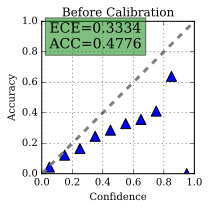

In [3]:
fig, ax = plt.subplots()
fig.set_figheight(3)
fig.set_figwidth(3)
ece, acc, ax = reliability_plot(ax, score, Y_true, NUM_BINS)
ax.set_title("Before Calibration")
fig.tight_layout()

In [4]:
# train a Spline regression model using all available data points as a reference model.
# MSE between this spline curve and the one trained on selected datapoints will be computed as a metric for evaluation.
gam_ref = LogisticGAM(s(0, constraints='monotonic_inc')).gridsearch(
                    np.max(score, axis=1).reshape(-1, 1),
                    np.array(Y_true == Y_predict) * 1) # add a linear term

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.9297
Link Function:                        LogitLink Log Likelihood:                                 -6184.9432
Number of Samples:                        10000 AIC:                                            12377.7458
                                                AICc:                                           12377.7517
                                                UBRE:                                               3.2381
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1064
Feature Function                  Lam

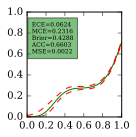

In [5]:
# feed all data into spline regression
fig, ax = plt.subplots()
fig.set_figheight(2)
fig.set_figwidth(2)
ece, mce, brier, acc, mse, ax, confi = spline_classification_plot(ax,
                           np.max(score, axis=1).reshape(-1, 1),
                           np.array(Y_true == Y_predict) * 1,
                           np.max(score, axis=1).reshape(-1, 1),
                           np.array(Y_true == Y_predict) * 1,
                           gam_ref)
fig.tight_layout()

# active learning

In [6]:
training_list = [i for i in range(N)]
subset_init = np.random.choice(training_list, size = NUM_SAMPLES[0], replace = False).tolist()

### randomly select datapoints and feed to spline regression

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                         2.0
Link Function:                        LogitLink Log Likelihood:                                   -10.6459
Number of Samples:                           20 AIC:                                                25.292
                                                AICc:                                               26.792
                                                UBRE:                                               3.3446
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2091
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                    -16.854
Number of Samples:                           30 AIC:                                               37.7081
                                                AICc:                                              38.6312
                                                UBRE:                                               3.3103
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1895
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                   -24.8488
Number of Samples:                           40 AIC:                                               53.6977
                                                AICc:                                              54.3644
                                                UBRE:                                               3.3824
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0889
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                   -31.8475
Number of Samples:                           50 AIC:                                               67.6951
                                                AICc:                                              68.2169
                                                UBRE:                                               3.3859
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0637
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                    -39.109
Number of Samples:                           60 AIC:                                               82.2182
                                                AICc:                                              82.6469
                                                UBRE:                                                3.397
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0474
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0002
Link Function:                        LogitLink Log Likelihood:                                   -46.6277
Number of Samples:                           70 AIC:                                               97.2558
                                                AICc:                                              97.6195
                                                UBRE:                                               3.4122
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0246
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.6272
Link Function:                        LogitLink Log Likelihood:                                   -51.6749
Number of Samples:                           80 AIC:                                              108.6042
                                                AICc:                                             109.0495
                                                UBRE:                                               3.3838
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0469
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.2686
Link Function:                        LogitLink Log Likelihood:                                   -58.7582
Number of Samples:                           90 AIC:                                              122.0537
                                                AICc:                                             122.3792
                                                UBRE:                                               3.3763
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0413
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.2791
Link Function:                        LogitLink Log Likelihood:                                   -64.7414
Number of Samples:                          100 AIC:                                               134.041
                                                AICc:                                             134.3342
                                                UBRE:                                               3.3586
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0483
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.5353
Link Function:                        LogitLink Log Likelihood:                                   -93.6436
Number of Samples:                          150 AIC:                                              192.3577
                                                AICc:                                             192.5781
                                                UBRE:                                               3.2959
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0793
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.5743
Link Function:                        LogitLink Log Likelihood:                                  -128.2589
Number of Samples:                          200 AIC:                                              261.6663
                                                AICc:                                             261.8336
                                                UBRE:                                               3.3186
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0615
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.3864
Link Function:                        LogitLink Log Likelihood:                                  -160.6851
Number of Samples:                          250 AIC:                                               326.143
                                                AICc:                                             326.2639
                                                UBRE:                                               3.3122
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0601
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.6177
Link Function:                        LogitLink Log Likelihood:                                  -190.7251
Number of Samples:                          300 AIC:                                              386.6857
                                                AICc:                                             386.7988
                                                UBRE:                                               3.2959
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0696
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.6342
Link Function:                        LogitLink Log Likelihood:                                  -226.9661
Number of Samples:                          350 AIC:                                              459.2007
                                                AICc:                                             459.2982
                                                UBRE:                                                3.318
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0546
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       2.489
Link Function:                        LogitLink Log Likelihood:                                  -259.7123
Number of Samples:                          400 AIC:                                              524.4027
                                                AICc:                                             524.4819
                                                UBRE:                                                3.316
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0526
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.5404
Link Function:                        LogitLink Log Likelihood:                                  -292.3624
Number of Samples:                          450 AIC:                                              589.8056
                                                AICc:                                             589.8778
                                                UBRE:                                               3.3152
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0513
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.5541
Link Function:                        LogitLink Log Likelihood:                                  -324.5773
Number of Samples:                          500 AIC:                                              654.2629
                                                AICc:                                             654.3282
                                                UBRE:                                               3.3126
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0555
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       2.805
Link Function:                        LogitLink Log Likelihood:                                  -356.4597
Number of Samples:                          550 AIC:                                              718.5293
                                                AICc:                                             718.5964
                                                UBRE:                                               3.3105
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0574
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.8063
Link Function:                        LogitLink Log Likelihood:                                  -389.5846
Number of Samples:                          600 AIC:                                              784.7818
                                                AICc:                                             784.8433
                                                UBRE:                                               3.3117
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.056
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.5585
Link Function:                        LogitLink Log Likelihood:                                  -419.7932
Number of Samples:                          650 AIC:                                              844.7035
                                                AICc:                                             844.7537
                                                UBRE:                                               3.3027
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0599
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.8051
Link Function:                        LogitLink Log Likelihood:                                  -451.5692
Number of Samples:                          700 AIC:                                              908.7484
                                                AICc:                                              908.801
                                                UBRE:                                               3.3014
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0609
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.8141
Link Function:                        LogitLink Log Likelihood:                                  -485.0012
Number of Samples:                          750 AIC:                                              975.6306
                                                AICc:                                             975.6799
                                                UBRE:                                               3.3038
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0597
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.8113
Link Function:                        LogitLink Log Likelihood:                                   -514.478
Number of Samples:                          800 AIC:                                             1034.5786
                                                AICc:                                            1034.6247
                                                UBRE:                                                3.296
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0664
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.8047
Link Function:                        LogitLink Log Likelihood:                                   -545.583
Number of Samples:                          850 AIC:                                             1096.7753
                                                AICc:                                            1096.8185
                                                UBRE:                                                3.293
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0671
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.8096
Link Function:                        LogitLink Log Likelihood:                                  -573.6529
Number of Samples:                          900 AIC:                                             1152.9249
                                                AICc:                                            1152.9659
                                                UBRE:                                               3.2835
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0731
Feature Function                  Lam

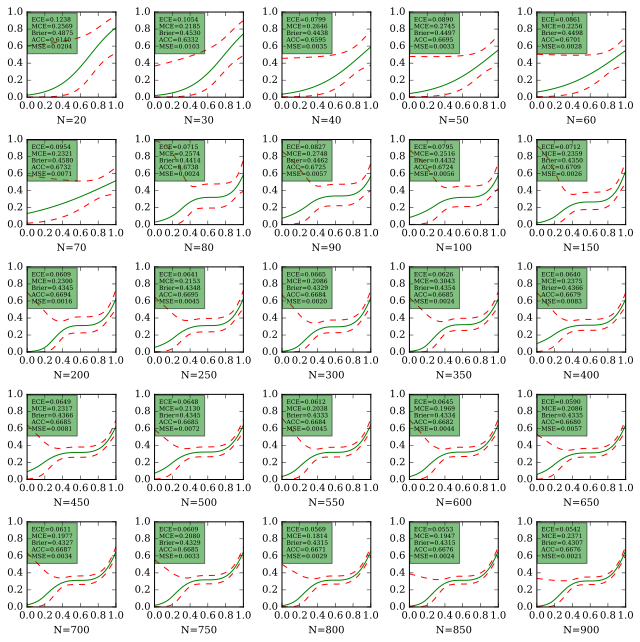

In [7]:
ece_random_emp, mce_random_emp, brier_random_emp, acc_random_emp, mse_random_emp, subset_random_emp = active_learning_plot(
    score, Y_predict, Y_true, acq_random_emp, subset_init, training_list, NUM_SAMPLES, gam_ref)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                         2.0
Link Function:                        LogitLink Log Likelihood:                                   -10.6459
Number of Samples:                           20 AIC:                                                25.292
                                                AICc:                                               26.792
                                                UBRE:                                               3.3446
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2091
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                   -18.2968
Number of Samples:                           30 AIC:                                               40.5937
                                                AICc:                                              41.5168
                                                UBRE:                                               3.4065
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1173
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                   -23.1606
Number of Samples:                           40 AIC:                                               50.3213
                                                AICc:                                               50.988
                                                UBRE:                                                3.298
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1586
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                   -27.7576
Number of Samples:                           50 AIC:                                               59.5153
                                                AICc:                                              60.0371
                                                UBRE:                                               3.2223
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.184
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                    -31.412
Number of Samples:                           60 AIC:                                               66.8243
                                                AICc:                                              67.2529
                                                UBRE:                                               3.1404
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2135
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                   -33.7999
Number of Samples:                           70 AIC:                                                  71.6
                                                AICc:                                              71.9637
                                                UBRE:                                               3.0457
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2591
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.0821
Link Function:                        LogitLink Log Likelihood:                                   -39.7205
Number of Samples:                           80 AIC:                                               85.6053
                                                AICc:                                              86.1591
                                                UBRE:                                               3.1009
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2418
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                   -44.8418
Number of Samples:                           90 AIC:                                               93.6839
                                                AICc:                                               93.963
                                                UBRE:                                               3.0587
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2172
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.4025
Link Function:                        LogitLink Log Likelihood:                                   -47.0603
Number of Samples:                          100 AIC:                                              100.9256
                                                AICc:                                             101.4284
                                                UBRE:                                               3.0365
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2399
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.4957
Link Function:                        LogitLink Log Likelihood:                                   -77.8947
Number of Samples:                          150 AIC:                                              162.7807
                                                AICc:                                             163.1227
                                                UBRE:                                               3.1038
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1953
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0003
Link Function:                        LogitLink Log Likelihood:                                   -103.173
Number of Samples:                          200 AIC:                                              210.3466
                                                AICc:                                             210.4691
                                                UBRE:                                               3.0597
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1613
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0004
Link Function:                        LogitLink Log Likelihood:                                  -128.0996
Number of Samples:                          250 AIC:                                                 260.2
                                                AICc:                                             260.2975
                                                UBRE:                                               3.0472
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1612
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0005
Link Function:                        LogitLink Log Likelihood:                                  -157.8171
Number of Samples:                          300 AIC:                                              319.6352
                                                AICc:                                             319.7163
                                                UBRE:                                               3.0708
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1388
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       3.448
Link Function:                        LogitLink Log Likelihood:                                  -184.2552
Number of Samples:                          350 AIC:                                              375.4066
                                                AICc:                                             375.5472
                                                UBRE:                                               3.0805
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1416
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.1171
Link Function:                        LogitLink Log Likelihood:                                  -211.3708
Number of Samples:                          400 AIC:                                              428.9758
                                                AICc:                                             429.0825
                                                UBRE:                                               3.0787
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1408
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0007
Link Function:                        LogitLink Log Likelihood:                                  -240.2134
Number of Samples:                          450 AIC:                                              484.4281
                                                AICc:                                              484.482
                                                UBRE:                                               3.0801
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1414
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.5269
Link Function:                        LogitLink Log Likelihood:                                  -263.7869
Number of Samples:                          500 AIC:                                              534.6276
                                                AICc:                                             534.7288
                                                UBRE:                                               3.0749
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                     0.15
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.1784
Link Function:                        LogitLink Log Likelihood:                                  -293.4104
Number of Samples:                          550 AIC:                                              593.1777
                                                AICc:                                             593.2571
                                                UBRE:                                               3.0831
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1373
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.1999
Link Function:                        LogitLink Log Likelihood:                                  -320.5904
Number of Samples:                          600 AIC:                                              647.5806
                                                AICc:                                              647.654
                                                UBRE:                                               3.0836
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1388
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.2295
Link Function:                        LogitLink Log Likelihood:                                  -350.6272
Number of Samples:                          650 AIC:                                              707.7134
                                                AICc:                                              707.782
                                                UBRE:                                               3.0928
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.133
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.2428
Link Function:                        LogitLink Log Likelihood:                                  -382.7612
Number of Samples:                          700 AIC:                                              772.0081
                                                AICc:                                             772.0721
                                                UBRE:                                               3.1066
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1231
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.2742
Link Function:                        LogitLink Log Likelihood:                                  -417.3638
Number of Samples:                          750 AIC:                                              841.2761
                                                AICc:                                             841.3367
                                                UBRE:                                               3.1252
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1137
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.2829
Link Function:                        LogitLink Log Likelihood:                                   -442.541
Number of Samples:                          800 AIC:                                              891.6478
                                                AICc:                                             891.7047
                                                UBRE:                                               3.1178
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1149
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.2906
Link Function:                        LogitLink Log Likelihood:                                  -471.5669
Number of Samples:                          850 AIC:                                              949.7151
                                                AICc:                                             949.7688
                                                UBRE:                                               3.1204
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1125
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       3.324
Link Function:                        LogitLink Log Likelihood:                                  -502.6115
Number of Samples:                          900 AIC:                                             1011.8711
                                                AICc:                                            1011.9226
                                                UBRE:                                               3.1273
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1079
Feature Function                  Lam

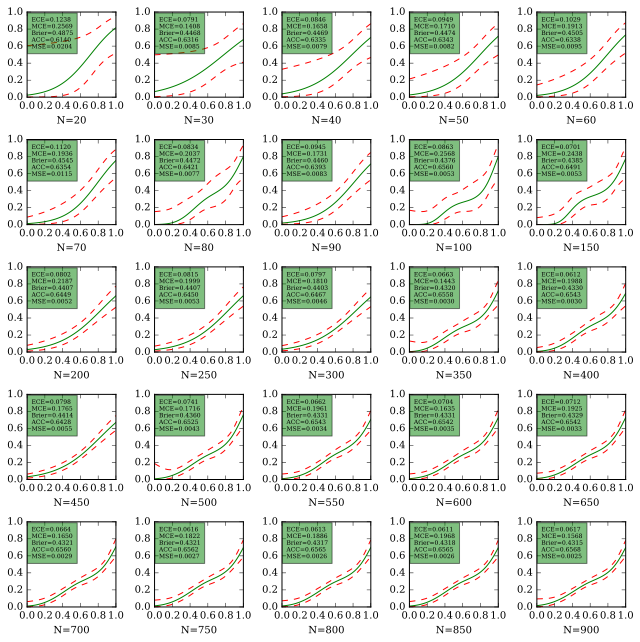

In [8]:
ece_random_unf, mce_random_unf, brier_random_unf, acc_random_unf, mse_random_unf, subset_random_unf = active_learning_plot(
    score, Y_predict, Y_true, acq_random_unf, subset_init, training_list, NUM_SAMPLES, gam_ref)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                         2.0
Link Function:                        LogitLink Log Likelihood:                                   -10.6459
Number of Samples:                           20 AIC:                                                25.292
                                                AICc:                                               26.792
                                                UBRE:                                               3.3446
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2091
Feature Function                  Lam

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

did not converge


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                   -14.4992
Number of Samples:                           30 AIC:                                               32.9985
                                                AICc:                                              33.9217
                                                UBRE:                                               3.1533
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3005
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                   -19.0686
Number of Samples:                           40 AIC:                                               42.1374
                                                AICc:                                              42.8041
                                                UBRE:                                               3.0934
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2794
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                    -23.404
Number of Samples:                           50 AIC:                                               50.8081
                                                AICc:                                              51.3298
                                                UBRE:                                               3.0482
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2836
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                   -29.6518
Number of Samples:                           60 AIC:                                               63.3039
                                                AICc:                                              63.7325
                                                UBRE:                                               3.0817
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2236
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                   -33.2338
Number of Samples:                           70 AIC:                                               70.4679
                                                AICc:                                              70.8316
                                                UBRE:                                               3.0295
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2373
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.3565
Link Function:                        LogitLink Log Likelihood:                                   -38.6706
Number of Samples:                           80 AIC:                                               82.0543
                                                AICc:                                               82.441
                                                UBRE:                                               3.0492
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.244
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0002
Link Function:                        LogitLink Log Likelihood:                                   -46.2358
Number of Samples:                           90 AIC:                                                96.472
                                                AICc:                                              96.7511
                                                UBRE:                                               3.0897
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2022
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0002
Link Function:                        LogitLink Log Likelihood:                                   -51.8488
Number of Samples:                          100 AIC:                                              107.6981
                                                AICc:                                             107.9481
                                                UBRE:                                                3.093
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1912
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0003
Link Function:                        LogitLink Log Likelihood:                                   -79.8752
Number of Samples:                          150 AIC:                                               163.751
                                                AICc:                                             163.9154
                                                UBRE:                                               3.1023
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1361
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0004
Link Function:                        LogitLink Log Likelihood:                                  -111.9785
Number of Samples:                          200 AIC:                                              227.9578
                                                AICc:                                             228.0803
                                                UBRE:                                               3.1478
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0897
Feature Function                  Lam

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

did not converge


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0004
Link Function:                        LogitLink Log Likelihood:                                  -137.3794
Number of Samples:                          250 AIC:                                              278.7596
                                                AICc:                                             278.8572
                                                UBRE:                                               3.1214
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0901
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0005
Link Function:                        LogitLink Log Likelihood:                                  -163.9338
Number of Samples:                          300 AIC:                                              331.8686
                                                AICc:                                             331.9497
                                                UBRE:                                               3.1116
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0833
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0006
Link Function:                        LogitLink Log Likelihood:                                  -194.9759
Number of Samples:                          350 AIC:                                              393.9529
                                                AICc:                                             394.0222
                                                UBRE:                                               3.1302
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0689
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0006
Link Function:                        LogitLink Log Likelihood:                                  -221.7021
Number of Samples:                          400 AIC:                                              447.4054
                                                AICc:                                             447.4661
                                                UBRE:                                               3.1225
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0653
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0007
Link Function:                        LogitLink Log Likelihood:                                  -252.7126
Number of Samples:                          450 AIC:                                              509.4266
                                                AICc:                                             509.4804
                                                UBRE:                                               3.1356
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0689
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0008
Link Function:                        LogitLink Log Likelihood:                                  -284.9884
Number of Samples:                          500 AIC:                                              573.9784
                                                AICc:                                             574.0268
                                                UBRE:                                               3.1512
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0643
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       3.265
Link Function:                        LogitLink Log Likelihood:                                  -310.0702
Number of Samples:                          550 AIC:                                              626.6705
                                                AICc:                                             626.7529
                                                UBRE:                                               3.1442
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0724
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.7936
Link Function:                        LogitLink Log Likelihood:                                  -339.0735
Number of Samples:                          600 AIC:                                              685.7343
                                                AICc:                                             685.8278
                                                UBRE:                                               3.1479
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0705
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.8258
Link Function:                        LogitLink Log Likelihood:                                    -369.03
Number of Samples:                          650 AIC:                                              745.7116
                                                AICc:                                             745.7989
                                                UBRE:                                                3.152
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0706
Feature Function                  Lam

 72% (8 of 11) |##################       | Elapsed Time: 0:00:01 ETA:   0:00:00

did not converge


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.8653
Link Function:                        LogitLink Log Likelihood:                                   -394.341
Number of Samples:                          700 AIC:                                              796.4126
                                                AICc:                                             796.4948
                                                UBRE:                                               3.1421
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0703
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.6967
Link Function:                        LogitLink Log Likelihood:                                  -419.3315
Number of Samples:                          750 AIC:                                              846.0563
                                                AICc:                                             846.1282
                                                UBRE:                                                3.132
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.076
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.7004
Link Function:                        LogitLink Log Likelihood:                                  -449.2751
Number of Samples:                          800 AIC:                                               905.951
                                                AICc:                                             906.0184
                                                UBRE:                                               3.1361
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0791
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       3.709
Link Function:                        LogitLink Log Likelihood:                                  -478.6027
Number of Samples:                          850 AIC:                                              964.6233
                                                AICc:                                              964.687
                                                UBRE:                                               3.1383
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0767
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.7239
Link Function:                        LogitLink Log Likelihood:                                  -507.9348
Number of Samples:                          900 AIC:                                             1023.3174
                                                AICc:                                            1023.3779
                                                UBRE:                                               3.1403
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0732
Feature Function                  Lam

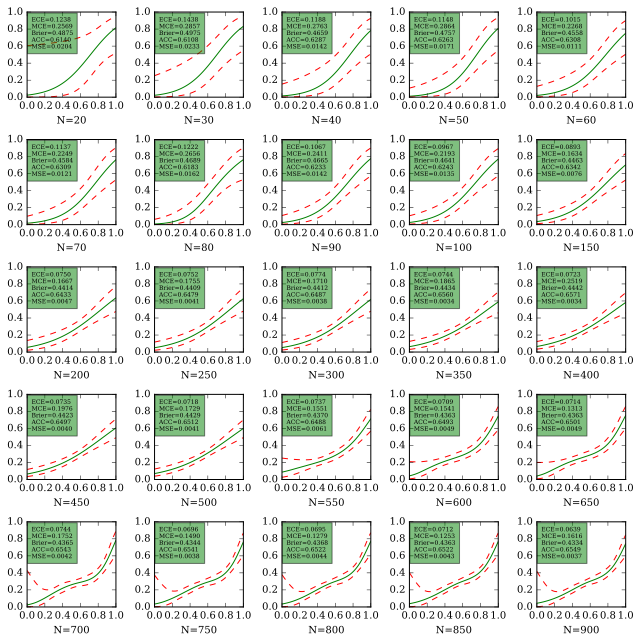

In [9]:
ece_random_ent, mce_random_ent, brier_random_ent, acc_random_ent, mse_random_ent, subset_random_ent = active_learning_plot(
    score, Y_predict, Y_true, acq_random_ent, subset_init, training_list, NUM_SAMPLES, gam_ref)

### actively select datapoints and feed into spline regression

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                         2.0
Link Function:                        LogitLink Log Likelihood:                                   -10.6459
Number of Samples:                           20 AIC:                                                25.292
                                                AICc:                                               26.792
                                                UBRE:                                               3.3446
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2091
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.5135
Link Function:                        LogitLink Log Likelihood:                                   -16.0008
Number of Samples:                           30 AIC:                                               37.0287
                                                AICc:                                              38.2732
                                                UBRE:                                               3.3013
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1884
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.5966
Link Function:                        LogitLink Log Likelihood:                                   -23.4714
Number of Samples:                           40 AIC:                                               52.1359
                                                AICc:                                              53.0698
                                                UBRE:                                               3.3553
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1473
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.4315
Link Function:                        LogitLink Log Likelihood:                                   -28.9095
Number of Samples:                           50 AIC:                                                62.682
                                                AICc:                                              63.3494
                                                UBRE:                                               3.2925
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.162
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.4451
Link Function:                        LogitLink Log Likelihood:                                   -33.1712
Number of Samples:                           60 AIC:                                               71.2325
                                                AICc:                                              71.7838
                                                UBRE:                                               3.2198
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1966
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.4797
Link Function:                        LogitLink Log Likelihood:                                   -40.1632
Number of Samples:                           70 AIC:                                               85.2857
                                                AICc:                                              85.7615
                                                UBRE:                                               3.2467
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1678
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.6883
Link Function:                        LogitLink Log Likelihood:                                   -45.3213
Number of Samples:                           80 AIC:                                               96.0193
                                                AICc:                                              96.4785
                                                UBRE:                                               3.2271
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1794
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       2.672
Link Function:                        LogitLink Log Likelihood:                                   -52.2111
Number of Samples:                           90 AIC:                                              109.7664
                                                AICc:                                             110.1685
                                                UBRE:                                               3.2434
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1555
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.6924
Link Function:                        LogitLink Log Likelihood:                                   -58.8143
Number of Samples:                          100 AIC:                                              123.0135
                                                AICc:                                             123.3771
                                                UBRE:                                               3.2517
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1475
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.6707
Link Function:                        LogitLink Log Likelihood:                                   -86.7024
Number of Samples:                          150 AIC:                                              178.7462
                                                AICc:                                             178.9821
                                                UBRE:                                               3.2059
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1622
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.1075
Link Function:                        LogitLink Log Likelihood:                                  -120.3653
Number of Samples:                          200 AIC:                                              246.9457
                                                AICc:                                              247.161
                                                UBRE:                                               3.2472
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1277
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.7853
Link Function:                        LogitLink Log Likelihood:                                  -149.8885
Number of Samples:                          250 AIC:                                              305.3476
                                                AICc:                                             305.4953
                                                UBRE:                                               3.2303
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1318
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.7973
Link Function:                        LogitLink Log Likelihood:                                  -177.7158
Number of Samples:                          300 AIC:                                              361.0261
                                                AICc:                                             361.1495
                                                UBRE:                                               3.2109
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1449
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.8101
Link Function:                        LogitLink Log Likelihood:                                  -211.0061
Number of Samples:                          350 AIC:                                              427.6324
                                                AICc:                                             427.7386
                                                UBRE:                                               3.2282
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1302
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.7925
Link Function:                        LogitLink Log Likelihood:                                  -241.5992
Number of Samples:                          400 AIC:                                              488.7834
                                                AICc:                                             488.8754
                                                UBRE:                                               3.2275
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1284
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       2.797
Link Function:                        LogitLink Log Likelihood:                                  -271.5285
Number of Samples:                          450 AIC:                                               548.651
                                                AICc:                                             548.7328
                                                UBRE:                                               3.2242
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1289
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       2.671
Link Function:                        LogitLink Log Likelihood:                                  -305.3618
Number of Samples:                          500 AIC:                                              616.0656
                                                AICc:                                             616.1348
                                                UBRE:                                               3.2364
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1174
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.8314
Link Function:                        LogitLink Log Likelihood:                                  -331.2569
Number of Samples:                          550 AIC:                                              668.1767
                                                AICc:                                             668.2446
                                                UBRE:                                                3.219
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1284
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.8269
Link Function:                        LogitLink Log Likelihood:                                  -360.6477
Number of Samples:                          600 AIC:                                              726.9491
                                                AICc:                                             727.0112
                                                UBRE:                                               3.2154
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1313
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.8241
Link Function:                        LogitLink Log Likelihood:                                  -392.0287
Number of Samples:                          650 AIC:                                              789.7055
                                                AICc:                                             789.7627
                                                UBRE:                                               3.2184
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1292
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.8799
Link Function:                        LogitLink Log Likelihood:                                  -422.8928
Number of Samples:                          700 AIC:                                              851.5453
                                                AICc:                                             851.5998
                                                UBRE:                                               3.2198
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1281
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9859
Link Function:                        LogitLink Log Likelihood:                                  -455.0419
Number of Samples:                          750 AIC:                                              916.0554
                                                AICc:                                             916.1088
                                                UBRE:                                               3.2246
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1242
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.3272
Link Function:                        LogitLink Log Likelihood:                                  -483.9572
Number of Samples:                          800 AIC:                                              974.5689
                                                AICc:                                             974.6269
                                                UBRE:                                               3.2215
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1269
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.2964
Link Function:                        LogitLink Log Likelihood:                                  -510.3092
Number of Samples:                          850 AIC:                                             1027.2113
                                                AICc:                                            1027.2652
                                                UBRE:                                               3.2116
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1331
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9991
Link Function:                        LogitLink Log Likelihood:                                  -539.6078
Number of Samples:                          900 AIC:                                             1085.2137
                                                AICc:                                            1085.2584
                                                UBRE:                                               3.2085
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1342
Feature Function                  Lam

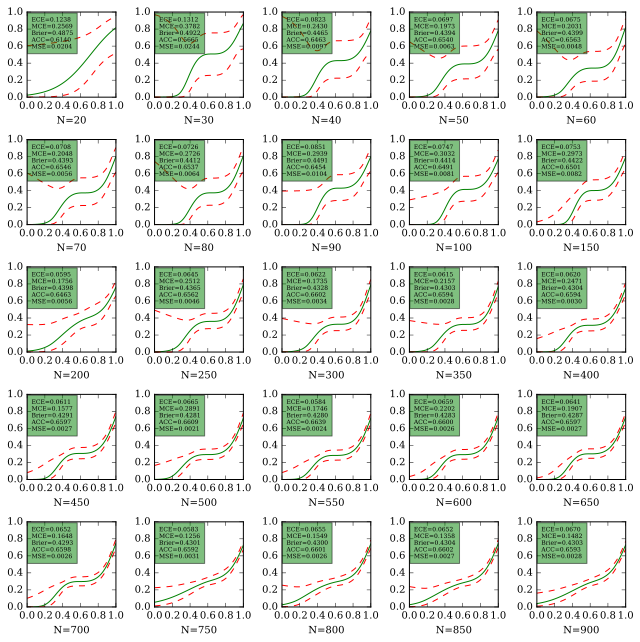

In [10]:
# reweight datapoints acccording to uncertainty
ece_active_prb, mce_active_prb, brier_active_prb, acc_active_prb, mse_active_prb, subset_active_prb = active_learning_plot(
    score, Y_predict, Y_true, acq_active_prb, subset_init, training_list, NUM_SAMPLES, gam_ref)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                         2.0
Link Function:                        LogitLink Log Likelihood:                                   -10.6459
Number of Samples:                           20 AIC:                                                25.292
                                                AICc:                                               26.792
                                                UBRE:                                               3.3446
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2091
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                         2.0
Link Function:                        LogitLink Log Likelihood:                                   -11.5503
Number of Samples:                           30 AIC:                                               27.1007
                                                AICc:                                              28.0238
                                                UBRE:                                               2.9567
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.4279
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                   -17.0119
Number of Samples:                           40 AIC:                                               38.0239
                                                AICc:                                              38.6906
                                                UBRE:                                               2.9906
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3431
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                   -24.6178
Number of Samples:                           50 AIC:                                               53.2357
                                                AICc:                                              53.7575
                                                UBRE:                                               3.0967
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2465
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.0713
Link Function:                        LogitLink Log Likelihood:                                   -25.0759
Number of Samples:                           60 AIC:                                               56.2943
                                                AICc:                                              57.0461
                                                UBRE:                                               2.9792
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3951
Feature Function                  Lam

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

did not converge


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.2358
Link Function:                        LogitLink Log Likelihood:                                    -30.112
Number of Samples:                           70 AIC:                                               66.6957
                                                AICc:                                              67.3806
                                                UBRE:                                               2.9898
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3701
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.2506
Link Function:                        LogitLink Log Likelihood:                                   -37.4815
Number of Samples:                           80 AIC:                                               81.4641
                                                AICc:                                              82.0613
                                                UBRE:                                               3.0508
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3163
Feature Function                  Lam

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

did not converge


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.2568
Link Function:                        LogitLink Log Likelihood:                                   -44.6913
Number of Samples:                           90 AIC:                                               95.8961
                                                AICc:                                              96.4242
                                                UBRE:                                               3.0945
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2772
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.3002
Link Function:                        LogitLink Log Likelihood:                                   -48.2573
Number of Samples:                          100 AIC:                                               103.115
                                                AICc:                                             103.5963
                                                UBRE:                                               3.0576
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.287
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       2.919
Link Function:                        LogitLink Log Likelihood:                                   -71.8954
Number of Samples:                          150 AIC:                                              149.6288
                                                AICc:                                             149.8945
                                                UBRE:                                               3.0131
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2414
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.5824
Link Function:                        LogitLink Log Likelihood:                                  -108.4581
Number of Samples:                          200 AIC:                                               222.081
                                                AICc:                                              222.249
                                                UBRE:                                               3.1207
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1834
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9461
Link Function:                        LogitLink Log Likelihood:                                  -115.1728
Number of Samples:                          250 AIC:                                              236.2377
                                                AICc:                                              236.397
                                                UBRE:                                               2.9544
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3353
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9573
Link Function:                        LogitLink Log Likelihood:                                  -150.0976
Number of Samples:                          300 AIC:                                              306.1098
                                                AICc:                                             306.2428
                                                UBRE:                                               3.0283
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.278
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9854
Link Function:                        LogitLink Log Likelihood:                                  -166.4504
Number of Samples:                          350 AIC:                                              338.8717
                                                AICc:                                             338.9869
                                                UBRE:                                                2.975
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3052
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9878
Link Function:                        LogitLink Log Likelihood:                                  -203.2371
Number of Samples:                          400 AIC:                                              412.4498
                                                AICc:                                             412.5505
                                                UBRE:                                               3.0371
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2593
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9888
Link Function:                        LogitLink Log Likelihood:                                  -233.8507
Number of Samples:                          450 AIC:                                               473.679
                                                AICc:                                             473.7685
                                                UBRE:                                               3.0579
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2377
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9895
Link Function:                        LogitLink Log Likelihood:                                  -265.9002
Number of Samples:                          500 AIC:                                              537.7796
                                                AICc:                                               537.86
                                                UBRE:                                               3.0803
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2168
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9795
Link Function:                        LogitLink Log Likelihood:                                  -308.7023
Number of Samples:                          550 AIC:                                              623.3636
                                                AICc:                                             623.4363
                                                UBRE:                                               3.1377
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1735
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9833
Link Function:                        LogitLink Log Likelihood:                                  -343.4043
Number of Samples:                          600 AIC:                                              692.7752
                                                AICc:                                             692.8419
                                                UBRE:                                               3.1586
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1587
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9845
Link Function:                        LogitLink Log Likelihood:                                   -355.114
Number of Samples:                          650 AIC:                                               716.197
                                                AICc:                                             716.2586
                                                UBRE:                                               3.1055
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2048
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9855
Link Function:                        LogitLink Log Likelihood:                                  -387.3221
Number of Samples:                          700 AIC:                                              780.6153
                                                AICc:                                             780.6725
                                                UBRE:                                               3.1186
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1925
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9858
Link Function:                        LogitLink Log Likelihood:                                  -401.7158
Number of Samples:                          750 AIC:                                              809.4033
                                                AICc:                                             809.4566
                                                UBRE:                                               3.0824
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2101
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9866
Link Function:                        LogitLink Log Likelihood:                                  -433.9119
Number of Samples:                          800 AIC:                                              873.7969
                                                AICc:                                             873.8469
                                                UBRE:                                               3.0952
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1981
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9881
Link Function:                        LogitLink Log Likelihood:                                  -464.8446
Number of Samples:                          850 AIC:                                              935.6654
                                                AICc:                                             935.7125
                                                UBRE:                                               3.1036
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1983
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9887
Link Function:                        LogitLink Log Likelihood:                                  -496.3376
Number of Samples:                          900 AIC:                                              998.6526
                                                AICc:                                             998.6971
                                                UBRE:                                               3.1123
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1893
Feature Function                  Lam

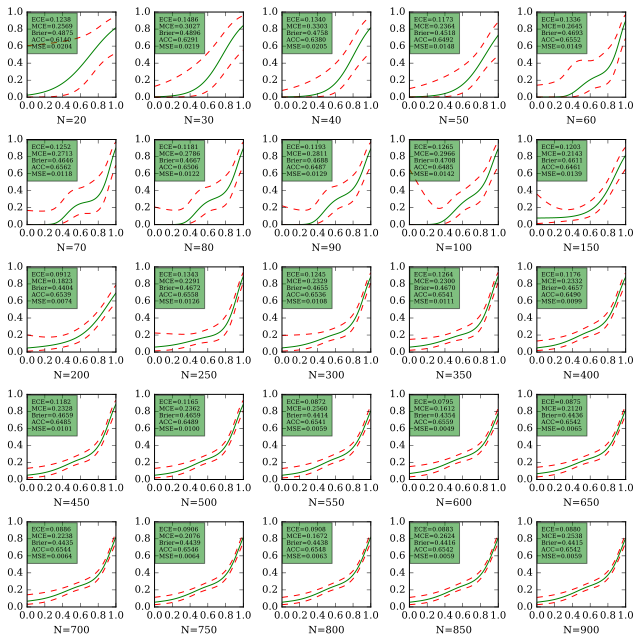

In [11]:
## select data points with highest uncertainty
ece_active_dtm, mce_active_dtm, brier_active_dtm, acc_active_dtm, mse_active_dtm,  subset_active_dtm = active_learning_plot(
    score, Y_predict, Y_true, acq_active_dtm, subset_init, training_list, NUM_SAMPLES, gam_ref)

### Compare different acquisition methods in a single run

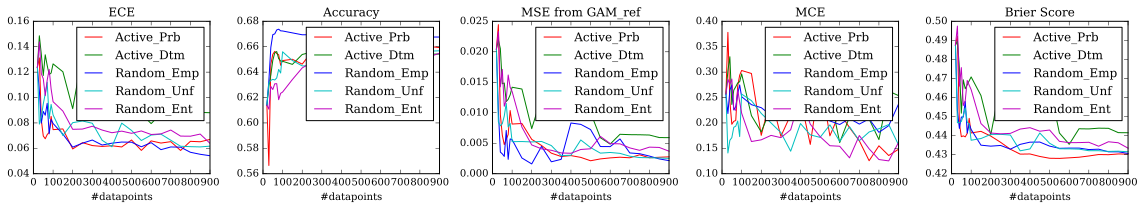

In [12]:
plot_metric_single_run(ece_random_emp, mce_random_emp, brier_random_emp, acc_random_emp, mse_random_emp,\
                       ece_random_unf, mce_random_unf, brier_random_unf, acc_random_unf, mse_random_unf,\
                       ece_random_ent, mce_random_ent, brier_random_ent, acc_random_ent, mse_random_ent,\
                       ece_active_prb, mce_active_prb, brier_active_prb, acc_active_prb, mse_active_prb,\
                       ece_active_dtm, mce_active_dtm, brier_active_dtm, acc_active_dtm, mse_active_dtm, NUM_SAMPLES)

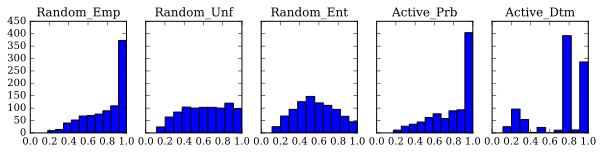

In [13]:
# compare the histogram of scores of datapoints selected with different methods
fig, ax = plt.subplots(nrows=1, ncols=5, sharey = True)
fig.set_figheight(2)
fig.set_figwidth(10)
ax[0].hist(np.max(score, axis=1).reshape(-1, 1)[subset_random_emp])
ax[0].set_xlim(0.0, 1.0)
ax[0].set_title("Random_Emp")
ax[1].hist(np.max(score, axis=1).reshape(-1, 1)[subset_random_unf])
ax[1].set_xlim(0.0, 1.0)
ax[1].set_title("Random_Unf")
ax[2].hist(np.max(score, axis=1).reshape(-1, 1)[subset_random_ent])
ax[2].set_xlim(0.0, 1.0)
ax[2].set_title("Random_Ent")
ax[3].hist(np.max(score, axis=1).reshape(-1, 1)[subset_active_prb])
ax[3].set_xlim(0.0, 1.0)
ax[3].set_title("Active_Prb")
ax[4].hist(np.max(score, axis=1).reshape(-1, 1)[subset_active_dtm])
ax[4].set_xlim(0.0, 1.0)
ax[4].set_title("Active_Dtm")

## Multiple runs to get errorbars

In [14]:
######### run spline_run.py for a given dataset for multiple runs.
# results will be written to output/DATASET with filenames ece_random.csv, 
# ece_active.csv, acc_random.csv, acc_active.csv.

# disij@datalab-5 22:19:44 ~/projects/sandbox/nn_assessor
# python spline_run.py

ece_random_emp_multi_run = LoadCsvFromOutput("output/%s/ece_random_emp.csv" % DATASET)
mce_random_emp_multi_run = LoadCsvFromOutput("output/%s/mce_random_emp.csv" % DATASET)
brier_random_emp_multi_run = LoadCsvFromOutput("output/%s/brier_random_emp.csv" % DATASET)
acc_random_emp_multi_run = LoadCsvFromOutput("output/%s/acc_random_emp.csv" % DATASET)
mse_random_emp_multi_run = LoadCsvFromOutput("output/%s/mse_random_emp.csv" % DATASET)

ece_random_unf_multi_run = LoadCsvFromOutput("output/%s/ece_random_unf.csv" % DATASET)
mce_random_unf_multi_run = LoadCsvFromOutput("output/%s/mce_random_unf.csv" % DATASET)
brier_random_unf_multi_run = LoadCsvFromOutput("output/%s/brier_random_unf.csv" % DATASET)
acc_random_unf_multi_run = LoadCsvFromOutput("output/%s/acc_random_unf.csv" % DATASET)
mse_random_unf_multi_run = LoadCsvFromOutput("output/%s/mse_random_unf.csv" % DATASET)

ece_random_ent_multi_run = LoadCsvFromOutput("output/%s/ece_random_ent.csv" % DATASET)
mce_random_ent_multi_run = LoadCsvFromOutput("output/%s/mce_random_ent.csv" % DATASET)
brier_random_ent_multi_run = LoadCsvFromOutput("output/%s/brier_random_ent.csv" % DATASET)
acc_random_ent_multi_run = LoadCsvFromOutput("output/%s/acc_random_ent.csv" % DATASET)
mse_random_ent_multi_run = LoadCsvFromOutput("output/%s/mse_random_ent.csv" % DATASET)

ece_active_prb_multi_run = LoadCsvFromOutput("output/%s/ece_active_prb.csv" % DATASET)
mce_active_prb_multi_run = LoadCsvFromOutput("output/%s/mce_active_prb.csv" % DATASET)
brier_active_prb_multi_run = LoadCsvFromOutput("output/%s/brier_active_prb.csv" % DATASET)
acc_active_prb_multi_run = LoadCsvFromOutput("output/%s/acc_active_prb.csv" % DATASET)
mse_active_prb_multi_run = LoadCsvFromOutput("output/%s/mse_active_prb.csv" % DATASET)

ece_active_dtm_multi_run = LoadCsvFromOutput("output/%s/ece_active_dtm.csv" % DATASET)
mce_active_dtm_multi_run = LoadCsvFromOutput("output/%s/mce_active_dtm.csv" % DATASET)
brier_active_dtm_multi_run = LoadCsvFromOutput("output/%s/brier_active_dtm.csv" % DATASET)
acc_active_dtm_multi_run = LoadCsvFromOutput("output/%s/acc_active_dtm.csv" % DATASET)
mse_active_dtm_multi_run = LoadCsvFromOutput("output/%s/mse_active_dtm.csv" % DATASET)

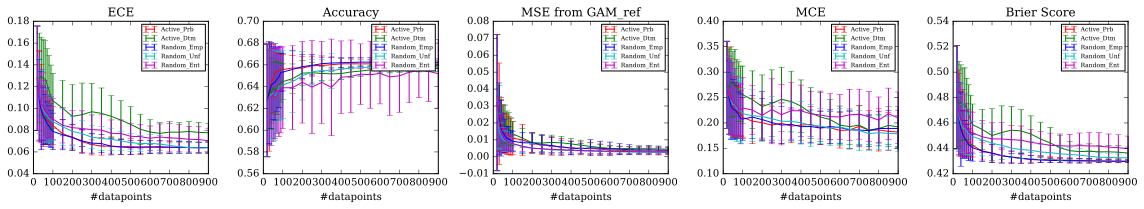

In [15]:
plot_metric_multi_run( ece_random_emp_multi_run, mce_random_emp_multi_run, brier_random_emp_multi_run, \
                              acc_random_emp_multi_run, mse_random_emp_multi_run,\
                       ece_random_unf_multi_run, mce_random_unf_multi_run, brier_random_unf_multi_run, \
                              acc_random_unf_multi_run, mse_random_unf_multi_run,\
                       ece_random_ent_multi_run, mce_random_ent_multi_run, brier_random_ent_multi_run, \
                              acc_random_ent_multi_run, mse_random_ent_multi_run,\
                       ece_active_prb_multi_run, mce_active_prb_multi_run, brier_active_prb_multi_run, \
                              acc_active_prb_multi_run, mse_active_prb_multi_run,\
                       ece_active_dtm_multi_run, mce_active_dtm_multi_run, brier_active_dtm_multi_run, \
                              acc_active_dtm_multi_run, mse_active_dtm_multi_run, NUM_SAMPLES)

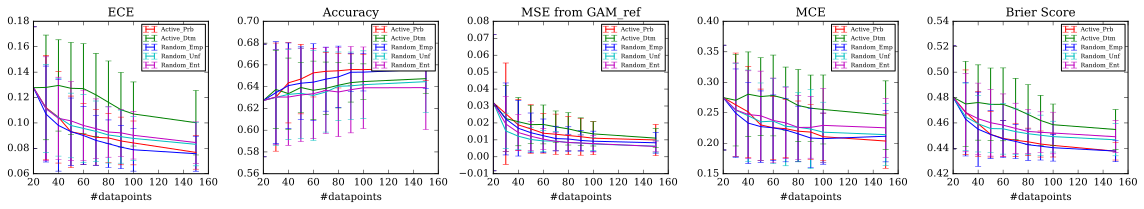

In [16]:
plot_metric_multi_run( ece_random_emp_multi_run, mce_random_emp_multi_run, brier_random_emp_multi_run, \
                              acc_random_emp_multi_run, mse_random_emp_multi_run,\
                       ece_random_unf_multi_run, mce_random_unf_multi_run, brier_random_unf_multi_run, \
                              acc_random_unf_multi_run, mse_random_unf_multi_run,\
                       ece_random_ent_multi_run, mce_random_ent_multi_run, brier_random_ent_multi_run, \
                              acc_random_ent_multi_run, mse_random_ent_multi_run,\
                       ece_active_prb_multi_run, mce_active_prb_multi_run, brier_active_prb_multi_run, \
                              acc_active_prb_multi_run, mse_active_prb_multi_run,\
                       ece_active_dtm_multi_run, mce_active_dtm_multi_run, brier_active_dtm_multi_run, \
                              acc_active_dtm_multi_run, mse_active_dtm_multi_run, NUM_SAMPLES[0:10])